<a href="https://colab.research.google.com/github/bibongbenh04/CKDTB/blob/master/Main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**include library**

In [1]:
# Cài đặt các thư viện cần thiết
!pip install wfdb numpy pandas scikit-learn keras-tuner matplotlib
!pip install tensorflow

import wfdb
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout, Flatten
import matplotlib.pyplot as plt
import os

from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.0/160.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 7.1 MB/s eta 0:00:00
Mounted at /content/drive


**Down load PPG and ABP signals from MIMIC III**

In [ ]:
!ls /content/physionet.org/files/mimicdb/1.0.0/225/

ls: cannot access '/content/physionet.org/files/mimicdb/1.0.0/225/': No such file or directory


In [ ]:
!wget -r -N -c -np https://physionet.org/files/mimicdb/1.0.0/225/

In [2]:
from scipy.signal import find_peaks
all_X = []
all_y = []

base_path = '/content/drive/MyDrive/physionet.org/files/mimicdb/1.0.0/225'

def extract_feature_points(signal, num_points=14):
    peaks, _ = find_peaks(signal)            # Tìm đỉnh
    valleys, _ = find_peaks(-signal)         # Tìm đáy
    extrema = np.sort(np.concatenate([peaks, valleys]))  # Kết hợp và sắp xếp đỉnh và đáy

    if len(extrema) < num_points:
        indices = np.linspace(0, len(signal) - 1, num_points, dtype=int)
    else:
        indices = np.linspace(0, len(extrema) - 1, num_points, dtype=int)
        indices = extrema[indices]

    return indices

for i in range(1, 10):
    record_name = f'22500{i:03d}'
    record_path = os.path.join(base_path, record_name)

    if os.path.isfile(record_path + '.dat'):
        signals, fields = wfdb.rdsamp(record_path)
        df_signals = pd.DataFrame(signals, columns=fields['sig_name'])

        df = df_signals[(df_signals['ABP'] > 80) & (df_signals['ABP'] < 180)]

        X = df[['PLETH']].values
        y = df['ABP'].values


        scaler = StandardScaler()
        X = scaler.fit_transform(X)

        all_X.append(X)
        all_y.append(y)
    else:
        print(f"Bản ghi {record_name} không tồn tại.")

if all_X and all_y:
    all_X = np.concatenate(all_X)
    all_y = np.concatenate(all_y)

    print("Dữ liệu đã được kết hợp thành công.")
else:
    print("Không có dữ liệu để kết hợp.")


Dữ liệu đã được kết hợp thành công.


In [ ]:
import matplotlib.pyplot as plt

if len(all_X) > 0 and len(all_y) > 0:
    ppg_sample = all_X[:1000].flatten()
    abp_sample = all_y[:1000]

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(ppg_sample, color='blue', label='PPG (PLETH)', alpha=0.8)
    plt.title('Tín hiệu PPG trước xử lý')
    plt.xlabel('Sample Index')
    plt.ylabel('PPG Amplitude')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.subplot(2, 1, 2)
    plt.plot(abp_sample, color='red', label='ABP', alpha=0.8)
    plt.title('Tín hiệu ABP trước xử lý')
    plt.xlabel('Sample Index')
    plt.ylabel('ABP (mmHg)')
    plt.legend()
    plt.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()
else:
    print("Không có dữ liệu để vẽ biểu đồ.")

print("Giá trị đầu vào (X):")
print(len(all_X))  # Hiển thị 5 dòng đầu tiên của all_X
print(all_X[:1000])  # Hiển thị 5 dòng đầu tiên của all_X

print("\nGiá trị mục tiêu (y):")
print(len(all_y))  # Hiển thị 5 dòng đầu tiên của all_X
print(all_y[:1000])

Giá trị đầu vào (X):
665832
[[ 1.29755058e+00]
 [ 1.16783722e+00]
 [ 1.03942098e+00]
 [ 9.03221944e-01]
 [ 7.73508575e-01]
 [ 6.64549345e-01]
 [ 5.62075784e-01]
 [ 4.67385025e-01]
 [ 3.92151271e-01]
 [ 3.44157325e-01]
 [ 2.89677710e-01]
 [ 2.49466565e-01]
 [ 1.59964341e-01]
 [ 1.18456063e-01]
 [ 5.10051113e-02]
 [-1.12573057e-02]
 [-9.29767279e-02]
 [-1.75993284e-01]
 [-2.71981177e-01]
 [-3.67969070e-01]
 [-4.63956962e-01]
 [-5.58647722e-01]
 [-6.41664278e-01]
 [-7.16898031e-01]
 [-7.92131785e-01]
 [-8.40125732e-01]
 [-8.94605347e-01]
 [-9.29627956e-01]
 [-9.69839100e-01]
 [-9.97078908e-01]
 [-1.02561585e+00]
 [-1.03210152e+00]
 [-1.05285566e+00]
 [-1.06582699e+00]
 [-1.07360980e+00]
 [-1.07360980e+00]
 [-1.07360980e+00]
 [-1.07360980e+00]
 [-1.06582699e+00]
 [-1.05285566e+00]
 [-1.03858719e+00]
 [-1.01783305e+00]
 [-1.00486171e+00]
 [-9.69839100e-01]
 [-9.56867764e-01]
 [-9.42599293e-01]
 [-9.15359486e-01]
 [-9.02388149e-01]
 [-8.81634010e-01]
 [-8.67365539e-01]
 [-8.54394202e-01]
 [-

In [3]:
print("Có giá trị NaN trong X:", np.isnan(all_X).any())
print("Có giá trị Inf trong X:", np.isinf(all_X).any())
print("Có giá trị NaN trong y:", np.isnan(all_y).any())
print("Có giá trị Inf trong y:", np.isinf(all_y).any())

df.fillna(df.mean(), inplace=True)
all_X = np.nan_to_num(all_X)
all_y = np.nan_to_num(all_y)

scaler = StandardScaler()
all_X = scaler.fit_transform(all_X)

def create_windows(data, labels, window_size):
    X_windows = []
    y_windows = []
    for i in range(len(data) - window_size):
        X_windows.append(data[i:i + window_size])
        y_windows.append(labels[i + window_size])
    return np.array(X_windows), np.array(y_windows)

window_size = 125
X_windows, y_windows = create_windows(all_X, all_y, window_size)

X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.2, random_state=42)

X_train = X_train.reshape(-1, window_size, 1)
X_test = X_test.reshape(-1, window_size, 1)

print(f'Kích thước X_train: {X_train.shape}, y_train: {y_train.shape}')
print(f'Kích thước X_test: {X_test.shape}, y_test: {y_test.shape}')
print(len(X_train[0]))

Có giá trị NaN trong X: True
Có giá trị Inf trong X: False
Có giá trị NaN trong y: False
Có giá trị Inf trong y: False


<ipython-input-3-299196f8faec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)


Kích thước X_train: (532565, 125, 1), y_train: (532565,)
Kích thước X_test: (133142, 125, 1), y_test: (133142,)
125


[ 37 123]


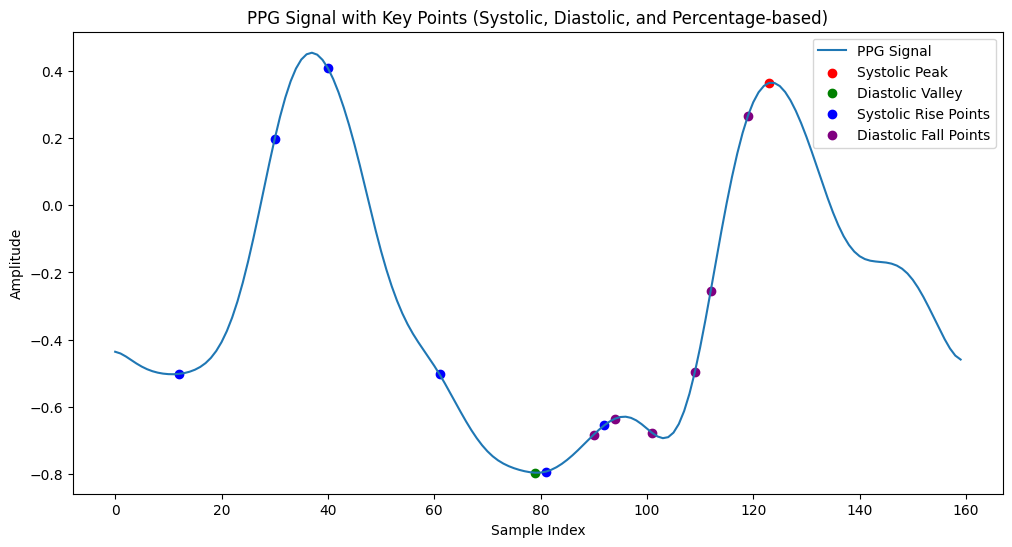

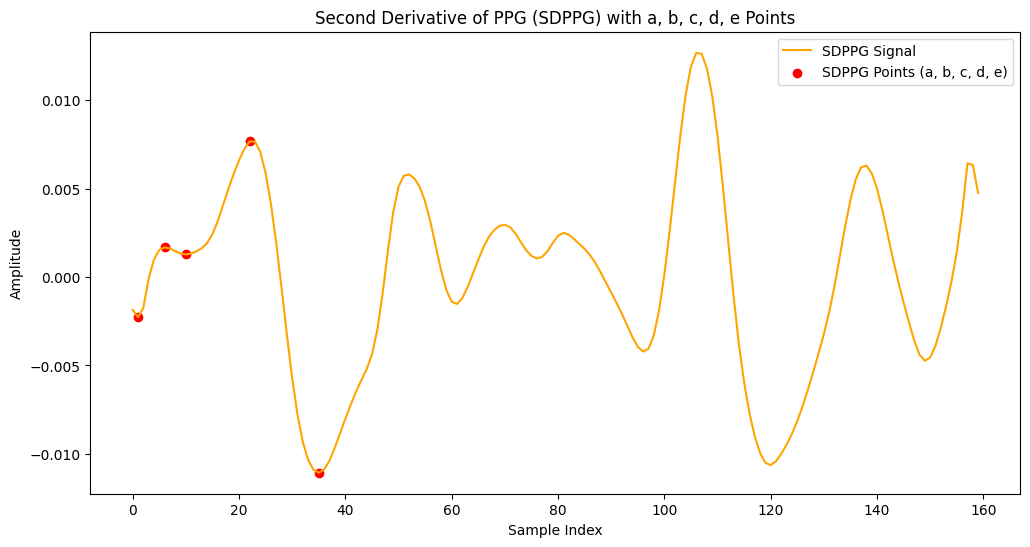

Systolic Time (S1): 123
Diastolic Time (DT): 79
Systolic Percentage Points: ST10, ST25, ST33, ST50, ST66, ST75 -> [12, 30, 40, 61, 81, 92]
Diastolic Percentage Points: DW10, DW25, DW33, DW50, DW66, DW75 -> [119, 112, 109, 101, 94, 90]
SDPPG Points (a, b, c, d, e): [1, 6, 10, 22, 35]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from numpy import gradient

pleth_signal = df['PLETH'].values[540:700]  # Use the first 1000 samples

smoothed_signal = gaussian_filter1d(pleth_signal, sigma=2)

first_derivative = gradient(smoothed_signal)

second_derivative = gradient(first_derivative)

systolic_peaks, _ = find_peaks(smoothed_signal, height=0.2)

diastolic_valleys, _ = find_peaks(-smoothed_signal, height=0.2)

systolic_time = systolic_peaks[1] if len(systolic_peaks) > 0 else None
diastolic_time = diastolic_valleys[1] if len(diastolic_valleys) > 0 else None

if systolic_time and diastolic_time:
    print(systolic_peaks)
    systolic_duration = systolic_time - 0

    diastolic_duration = diastolic_time - systolic_time

    ST10 = int(0.10 * systolic_time)
    ST25 = int(0.25 * systolic_time)
    ST33 = int(0.33 * systolic_time)
    ST50 = int(0.50 * systolic_time)
    ST66 = int(0.66 * systolic_time)
    ST75 = int(0.75 * systolic_time)

    DW10 = systolic_time + int(0.10 * diastolic_duration)
    DW25 = systolic_time + int(0.25 * diastolic_duration)
    DW33 = systolic_time + int(0.33 * diastolic_duration)
    DW50 = systolic_time + int(0.50 * diastolic_duration)
    DW66 = systolic_time + int(0.66 * diastolic_duration)
    DW75 = systolic_time + int(0.75 * diastolic_duration)

SDPPG_peaks, _ = find_peaks(second_derivative)
SDPPG_valleys, _ = find_peaks(-second_derivative)

a_point = SDPPG_valleys[0] if len(SDPPG_valleys) > 0 else None
b_point = SDPPG_peaks[0] if len(SDPPG_peaks) > 0 else None
c_point = SDPPG_valleys[1] if len(SDPPG_valleys) > 1 else None
d_point = SDPPG_peaks[1] if len(SDPPG_peaks) > 1 else None
e_point = SDPPG_valleys[2] if len(SDPPG_valleys) > 2 else None

# Plot the original PPG signal with extracted key points
plt.figure(figsize=(12, 6))
plt.plot(smoothed_signal, label='PPG Signal')
plt.scatter([systolic_time], [smoothed_signal[systolic_time]], color='red', label='Systolic Peak')
plt.scatter([diastolic_time], [smoothed_signal[diastolic_time]], color='green', label='Diastolic Valley')

# Plot percentage points for systolic and diastolic wave
plt.scatter([ST10, ST25, ST33, ST50, ST66, ST75], smoothed_signal[[ST10, ST25, ST33, ST50, ST66, ST75]], color='blue', label='Systolic Rise Points')
plt.scatter([DW10, DW25, DW33, DW50, DW66, DW75], smoothed_signal[[DW10, DW25, DW33, DW50, DW66, DW75]], color='purple', label='Diastolic Fall Points')

plt.title('PPG Signal with Key Points (Systolic, Diastolic, and Percentage-based)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot the second derivative (SDPPG) with a, b, c, d, e points
plt.figure(figsize=(12, 6))
plt.plot(second_derivative, label='SDPPG Signal', color='orange')
plt.scatter([a_point, b_point, c_point, d_point, e_point], second_derivative[[a_point, b_point, c_point, d_point, e_point]], color='red', label='SDPPG Points (a, b, c, d, e)')
plt.title('Second Derivative of PPG (SDPPG) with a, b, c, d, e Points')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Output extracted key points for reference
print("Systolic Time (S1):", systolic_time)
print("Diastolic Time (DT):", diastolic_time)
print("Systolic Percentage Points: ST10, ST25, ST33, ST50, ST66, ST75 ->", [ST10, ST25, ST33, ST50, ST66, ST75])
print("Diastolic Percentage Points: DW10, DW25, DW33, DW50, DW66, DW75 ->", [DW10, DW25, DW33, DW50, DW66, DW75])
print("SDPPG Points (a, b, c, d, e):", [a_point, b_point, c_point, d_point, e_point])


In [ ]:
print(X_train)

[[[ 1.09495705]
  [ 1.1027845 ]
  [ 1.08712961]
  ...
  [-0.85538139]
  [-0.89321405]
  [-0.91539181]]

 [[-0.64012665]
  [-0.68709132]
  [-0.7536246 ]
  ...
  [ 0.87839773]
  [ 0.8092553 ]
  [ 0.74924489]]

 [[-0.83711735]
  [-0.85407682]
  [-0.85407682]
  ...
  [ 1.89857476]
  [ 1.91422966]
  [ 1.90640221]]

 ...

 [[ 0.38005038]
  [ 0.34482688]
  [ 0.32134454]
  ...
  [-0.65317239]
  [-0.67665473]
  [-0.71057366]]

 [[ 0.38657326]
  [ 0.30699423]
  [ 0.2274152 ]
  ...
  [-1.12412368]
  [-0.98453424]
  [-0.81493959]]

 [[-0.68578675]
  [-0.55272018]
  [-0.39617127]
  ...
  [-0.68056845]
  [-0.69622334]
  [-0.71187823]]]


In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

fs = 1000  # Tần số mẫu, ví dụ 1000 Hz
epg_signal = X_train[:200].ravel() # Lấy dữ liệu EPG từ DataFrame
t = np.linspace(0, len(epg_signal) / fs, len(epg_signal), endpoint=False)

peaks, _ = signal.find_peaks(epg_signal)
troughs, _ = signal.find_peaks(-epg_signal)

distances = []
for i in range(len(peaks)):
    if i < len(troughs):
        distance = peaks[i] - troughs[i]
        distances.append(distance)

time_distances = [d / fs for d in distances]  # fs là tần số mẫu

print("Khoảng cách giữa các đỉnh và đáy (theo chỉ số):", distances)
print("Khoảng cách giữa các đỉnh và đáy (theo thời gian - giây):", time_distances)

Khoảng cách giữa các đỉnh và đáy (theo chỉ số): [-22, -17, -4, -7, -38, -6, -59, -12, -1, -8, -43, -5, -13, -2, -26, -13, -36, -67, -10, -62, -35, -6, -59, -10, -40, -10, -4, -19, -14, -18, -1, -10, -2, -8, -20, -9, -16, -8, -12, -11, -2, -4, -24, -9, -7, -10, -46, -18, -62, -37, -17, -15, -4, -19, -11, -2, -1, -1, -37, -2, -10, -38, -1, -19, -19, -19, -12, -9, -43, -10, -45, -20, -12, -4, -48, -37, -6, -1, -49, -2, -1, -37, -52, -24, -37, -5, -1, -55, -11, -9, -45, -24, -33, -4, -20, -20, -8, -46, -6, -16, -20, -11, -1, -23, -22, -3, -53, -1, -37, -2, -8, -46, -2, -8, -2, -25, -44, -31, -5, -22, -44, -23, -2, -6, -45, -17, -20, -39, -22, -38, -17, -1, -27, -16, -4, -8, -45, -4, -1, -41, -13, -1, -20, -14, -18, -35, -5, -22, -4, -25, -17, -9, -21, -31, -1, -59, -37, -1, -3, -17, -20, -9, -46, -1, -11, -4, -50, -7, -37, -37, -5, -17, -2, -7, -2, -2, -2, -50, -11, -48, -2, -31, -54, -2, -2, -20, -40, -57, -39, -1, -2, -8, -43, -26, -46, -11, -1, -1, -28, -5, -7, -1, -19, -1, -3, -18, -25

In [ ]:
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt

# Đảm bảo epg_signal có kích thước đúng (dữ liệu thực tế)
fs = 1000  # Tần số mẫu, ví dụ 1000 Hz
epg_signal = Í.values[:10000]  # Lấy dữ liệu EPG từ DataFrame
t = np.linspace(0, len(epg_signal) / fs, len(epg_signal), endpoint=False)

# Bước 1: Xác định đỉnh và đáy của sóng
peaks, _ = signal.find_peaks(epg_signal)
troughs, _ = signal.find_peaks(-epg_signal)

# Hiển thị kết quả ban đầu
plt.figure(figsize=(10, 6))
plt.plot(t, epg_signal, label='EPG Signal')
plt.plot(t[peaks], epg_signal[peaks], "x", label='Peaks')
plt.plot(t[troughs], epg_signal[troughs], "o", label='Troughs')

# Bước 2: Tách và hiển thị từng chu kỳ của sóng
num_points = 14  # Số điểm muốn lấy trong mỗi chu kỳ
all_cycles_points = []  # Lưu trữ 14 điểm của từng chu kỳ

for i in range(len(troughs) - 1):
    # Lấy một chu kỳ từ đáy hiện tại đến đáy kế tiếp
    start, end = troughs[i], troughs[i + 1]
    single_cycle = epg_signal[start:end + 1]

    # Lấy 14 điểm trong chu kỳ theo tỷ lệ phần trăm
    indices = np.linspace(0, len(single_cycle) - 1, num_points).astype(int)
    selected_points = single_cycle[indices]
    all_cycles_points.append(selected_points)

    # Vẽ chu kỳ và các điểm được chọn
    plt.plot(t[start:end+1], single_cycle, color='orange', label='Single Cycle' if i == 0 else "")
    plt.scatter(t[start + indices], selected_points, color='red', label='14 Points' if i == 0 else "")

# Hiển thị các đỉnh và đáy
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EPG Signal with All Cycles, Peaks, Troughs, and Selected Points')
plt.legend()
plt.show()

# In ra đỉnh và đáy của toàn bộ tín hiệu
print("Vị trí đỉnh (Peaks):", t[peaks])
print("Giá trị đỉnh:", epg_signal[peaks])
print("Vị trí đáy (Troughs):", t[troughs])
print("Giá trị đáy:", epg_signal[troughs])

# In ra 14 điểm của từng chu kỳ
for idx, cycle_points in enumerate(all_cycles_points):
    print(f"Chu kỳ {idx + 1} - 14 điểm theo tỷ lệ phần trăm:", cycle_points)

NameError: name 'Í' is not defined

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np

def build_model(input_shape):
    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='mean_squared_error',
                  metrics=['mae'])
    return model

input_shape = (X_train.shape[1], 1)
model = build_model(input_shape)

callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ModelCheckpoint('/content/drive/MyDrive/SaveModel/best_model.keras', monitor='val_loss', save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    callbacks=callbacks
)

loss, mae = model.evaluate(X_test, y_test)
print(f'MAE trên tập test: {mae:.2f} mmHg')

y_pred = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test[:100], label="Thực tế", marker='o', linestyle='dashed', markersize=3)
plt.plot(y_pred[:100], label="Dự đoán", marker='x', linestyle='solid', markersize=3)
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Blood Pressure (mmHg)')
plt.title('Thực tế vs Dự đoán Huyết áp')
plt.grid(alpha=0.3)
plt.show()

from sklearn.metrics import mean_squared_error, r2_score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'MSE: {mse:.2f}, R²: {r2:.2f}')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
6658/6658 ━━━━━━━━━━━━━━━━━━━━ 469s 70ms/step - loss: 9149.4736 - mae: 92.3206 - val_loss: 5044.9404 - val_mae: 66.9910
Epoch 2/50
6658/6658 ━━━━━━━━━━━━━━━━━━━━ 503s 70ms/step - loss: 4109.6362 - mae: 59.1958 - val_loss: 1857.7019 - val_mae: 36.0632
Epoch 3/50
6658/6658 ━━━━━━━━━━━━━━━━━━━━ 463s 70ms/step - loss: 1420.5770 - mae: 29.2420 - val_loss: 633.0787 - val_mae: 18.0405
Epoch 4/50
6658/6658 ━━━━━━━━━━━━━━━━━━━━ 482s 72ms/step - loss: 562.3713 - mae: 17.2878 - val_loss: 334.1636 - val_mae: 12.3395
Epoch 5/50
6658/6658 ━━━━━━━━━━━━━━━━━━━━ 483s 72ms/step - loss: 248.6998 - mae: 10.4714 - val_loss: 117.9738 - val_mae: 6.6433
Epoch 6/50
6658/6658 ━━━━━━━━━━━━━━━━━━━━ 493s 71ms/step - loss: 110.6733 - mae: 6.6349 - val_loss: 82.1355 - val_mae: 5.3430
Epoch 7/50
6658/6658 ━━━━━━━━━━━━━━━━━━━━ 468s 70ms/step - loss: 81.5755 - mae: 5.5593 - val_loss: 70.0484 - val_mae: 5.0711
Epoch 8/50
6658/6658 ━━━━━━━━━━━━━━━━━━━━ 515s 72ms/step - loss: 71.3194 - mae: 5.1579 - val_loss: 6

In [ ]:
loss, mae = model.evaluate(X_test, y_test)
print(f'MAE trên tập test: {mae:.2f} mmHg')


467/467 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - loss: 23.2052 - mae: 2.8746
MAE trên tập test: 2.88 mmHg


466/466 ━━━━━━━━━━━━━━━━━━━━ 7s 15ms/step


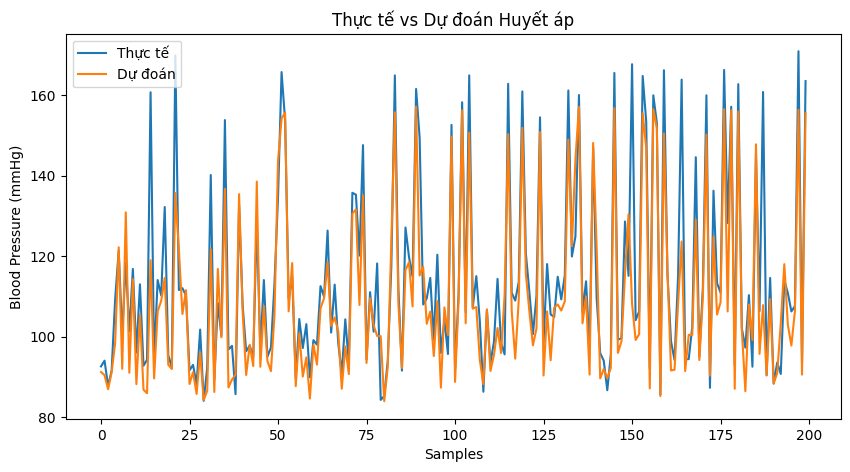

In [ ]:
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test[:200], label="Thực tế")
plt.plot(y_pred[:200], label="Dự đoán")
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Blood Pressure (mmHg)')
plt.title('Thực tế vs Dự đoán Huyết áp')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f} mmHg')
print(f'R²: {r2:.2f}')

RMSE: 4.95 mmHg
R²: 0.96


In [ ]:
print(df_filtered.describe())

                 II          MCL1             V           ABP         PLETH  \
count  74695.000000  74695.000000  74695.000000  74695.000000  74660.000000   
mean       0.027283     -0.003591     -0.003228    108.566010     -0.169001   
std        0.184012      0.219623      0.264172     24.487694      0.343985   
min       -0.682364     -1.199438     -1.477509     80.045011     -1.019500   
25%       -0.013850      0.001873      0.002307     89.197299     -0.466500   
50%        0.020314      0.011236      0.026528    101.650413     -0.282500   
75%        0.048938      0.114232      0.140715    121.005251      0.075125   
max        0.944598      0.186330      0.184544    179.519880      1.023500   

               RESP  
count  61086.000000  
mean       0.140725  
std        0.443998  
min       -0.682333  
25%       -0.234000  
50%        0.185333  
75%        0.585000  
max        0.682333  


In [ ]:
record_name = '/content/physionet.org/files/mimicdb/1.0.0/225/22500003'

signals, fields = wfdb.rdsamp(record_name)

df_signals = pd.DataFrame(signals, columns=fields['sig_name'])

df = df_signals[(df_signals['ABP'] > 80) & (df_signals['ABP'] < 180)]

print(df.head())

X = df[['PLETH']].values
y = df['ABP'].values

print("Có giá trị NaN trong X:", np.isnan(X).any())
print("Có giá trị Inf trong X:", np.isinf(X).any())
print("Có giá trị NaN trong y:", np.isnan(y).any())
print("Có giá trị Inf trong y:", np.isinf(y).any())

df.fillna(df.mean(), inplace=True)
X = np.nan_to_num(X)
y = np.nan_to_num(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

def create_windows(data, labels, window_size):
    X_windows = []
    y_windows = []
    for i in range(len(data) - window_size):
        X_windows.append(data[i:i + window_size])
        y_windows.append(labels[i + window_size])
    return np.array(X_windows), np.array(y_windows)

window_size = 125
X_windows, y_windows = create_windows(X, y, window_size)

X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.2, random_state=42)

         II      MCL1         V         ABP   PLETH  RESP
0  0.006464  0.108614  0.140715   84.621155 -0.6050   NaN
1  0.005540  0.124532  0.146482   87.921980 -0.6170   NaN
2  0.014774  0.124532  0.133795   92.798200 -0.6405   NaN
3  0.023084  0.124532  0.146482   99.099775 -0.6460   NaN
4  0.026777  0.124532  0.140715  106.751688 -0.6580   NaN
Có giá trị NaN trong X: True
Có giá trị Inf trong X: False
Có giá trị NaN trong y: False
Có giá trị Inf trong y: False


<ipython-input-60-5ce09e9fdad5>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)


4161/4161 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step


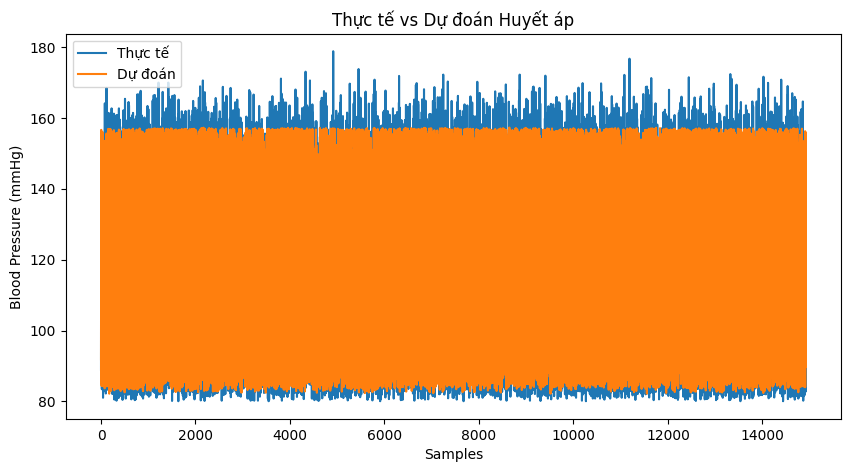

In [ ]:
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test[:14914], label="Thực tế")
plt.plot(y_pred[:14914], label="Dự đoán")
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Blood Pressure (mmHg)')
plt.title('Thực tế vs Dự đoán Huyết áp')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f} mmHg')
print(f'R²: {r2:.2f}')

RMSE: 8.47 mmHg
R²: 0.87


In [ ]:
record_name = '/content/physionet.org/files/mimicdb/1.0.0/225/22500004'

signals, fields = wfdb.rdsamp(record_name)

df_signals = pd.DataFrame(signals, columns=fields['sig_name'])

df = df_signals[(df_signals['ABP'] > 80) & (df_signals['ABP'] < 180)]

print(df.head())

X = df[['PLETH']].values
y = df['ABP'].values

print("Có giá trị NaN trong X:", np.isnan(X).any())
print("Có giá trị Inf trong X:", np.isinf(X).any())
print("Có giá trị NaN trong y:", np.isnan(y).any())
print("Có giá trị Inf trong y:", np.isinf(y).any())

df.fillna(df.mean(), inplace=True)
X = np.nan_to_num(X)
y = np.nan_to_num(y)

scaler = StandardScaler()
X = scaler.fit_transform(X)

def create_windows(data, labels, window_size):
    X_windows = []
    y_windows = []
    for i in range(len(data) - window_size):
        X_windows.append(data[i:i + window_size])
        y_windows.append(labels[i + window_size])
    return np.array(X_windows), np.array(y_windows)

window_size = 125
X_windows, y_windows = create_windows(X, y, window_size)

X_train, X_test, y_train, y_test = train_test_split(X_windows, y_windows, test_size=0.9, random_state=42)

         II      MCL1         V         ABP   PLETH  RESP
0  0.065559  0.145131  0.133795  156.264066 -0.3715   NaN
1  0.066482  0.139513  0.128028  158.889722 -0.3335   NaN
2  0.062789  0.124532  0.128028  160.015004 -0.2860   NaN
3  0.056325  0.124532  0.108420  159.939985 -0.2475   NaN
4  0.049861  0.108614  0.102653  158.964741 -0.1905   NaN
Có giá trị NaN trong X: False
Có giá trị Inf trong X: False
Có giá trị NaN trong y: False
Có giá trị Inf trong y: False


<ipython-input-63-8035520f0b6b>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.fillna(df.mean(), inplace=True)


In [ ]:
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test[:50], label="Thực tế")
plt.plot(y_pred[:50], label="Dự đoán")
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Blood Pressure (mmHg)')
plt.title('Thực tế vs Dự đoán Huyết áp')
plt.show()

NameError: name 'model' is not defined

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'RMSE: {rmse:.2f} mmHg')
print(f'R²: {r2:.2f}')

RMSE: 8.47 mmHg
R²: 0.87


In [ ]:
from tensorflow.keras.models import load_model
model.save('/content/drive/MyDrive/SaveModel/v1model.hdf5')

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 123, 64)             │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 61, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 61, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 59, 128)             │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 29, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 50)                  │          35,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 182,435 (712.64 KB)

 Trainable params: 60,811 (237.54 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 121,624 (475.10 KB)

4161/4161 ━━━━━━━━━━━━━━━━━━━━ 50s 12ms/step


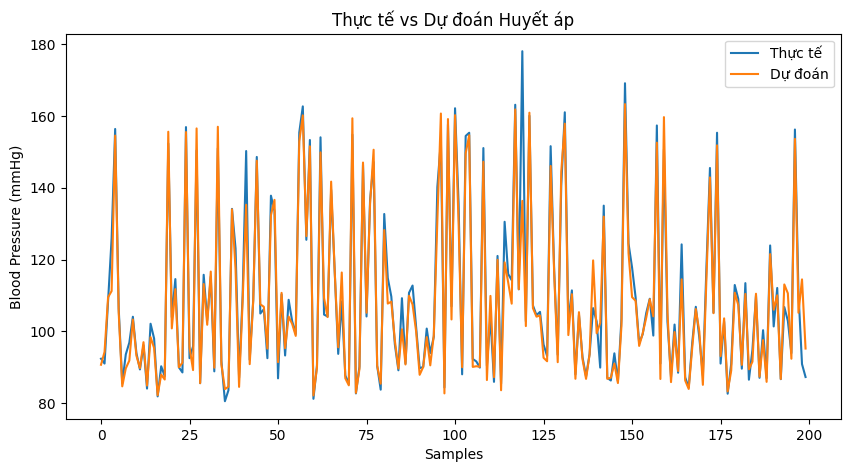

In [8]:
from tensorflow.keras.models import load_model
import numpy as np
import math
window_size = 200
start = np.random.randint(0, len(X_test) - window_size)
end = start + window_size

model_path = '/content/drive/MyDrive/SaveModel/best_model.keras'

model = load_model(model_path)

model.summary()
y_pred = model.predict(X_test)

plt.figure(figsize=(10, 5))
plt.plot(y_test[start:end], label="Thực tế")
plt.plot(y_pred[start:end], label="Dự đoán")
plt.legend()
plt.xlabel('Samples')
plt.ylabel('Blood Pressure (mmHg)')
plt.title('Thực tế vs Dự đoán Huyết áp')
plt.show()